In [10]:
import csv
import numpy as np
import matplotlib.pyplot as plt

EXPERTS =30
T= 3000
# h= sqrt(lnk/T)
experts_h= 0.22 

bandits_h= np.cbrt(EXPERTS*np.log(EXPERTS)/T)
epsilon= bandits_h
r= epsilon/EXPERTS

 # Bring in the dataset


bests = [0 for cxcx in range(30)]

with open("Milano_timeseries.csv", "r") as f:

    # initialize  reader
    dataset = list(csv.reader(f))

    servers = 30

    # for every round
    for round_number in range(T):
        
        #initialize best_load to infinite
        best_load = float("inf")

        # for every server
        for server_number in range(servers):

            # find the best  server for each round
            if float(dataset[server_number][round_number]) < best_load:
                best_server = server_number
                best_load = float(dataset[server_number][round_number])

        bests[best_server] += 1
bestof_best = np.argmax(bests)






Multiplicate Weights whith an Expert Enviroment


In [11]:
mw_best_score = np.zeros((T,))     # cumulative reward of best arm for round t
mw_inst_score = np.zeros((T,))     # reward for round t
mw_score = np.zeros((T,))          # cumulative reward for round t
mw_regret =  np.zeros((T,))        # regret for round t
mw_correct_predictions= 0

# initialize all weights to 1
weights = [1 for _ in range(EXPERTS)]


#initialize probs to pick an expert
probs = [1/EXPERTS for _ in range(EXPERTS)]

with open("Milano_timeseries.csv", "r") as f:

    # initialize reader
    dataset = list(csv.reader(f))

    servers = 30

    # for every round
    for round_number in range(T):

        # pick an expert with pi= wi(t)/Wi(t)
        expert = np.random.choice(EXPERTS, p=probs)

        # collect score of the expert
        mw_inst_score[round_number] = float(dataset[expert][round_number])

        #intiliaze best_load to infinite
        best_load = float("inf")

        # for every server
        for server_number in range(servers):

            # find the best  server for each round
            if float(dataset[server_number][round_number]) < best_load:
                best_server = server_number
                best_load = float(dataset[server_number][round_number])



        #calulate the loss at each round= load of the optimal server - load of picked server
        loss = [abs(best_load - float(dataset[i][round_number])) for i in range(EXPERTS)]

        #keep track of the correct guesses
        if best_load== mw_inst_score[round_number]: mw_correct_predictions+=1

        #calculate the weights for every expert even if expert wasnt played
        weights= [np.power(1-experts_h,loss[i] )*weights[i] for i in range (EXPERTS)]

        probs= [weights[i]/sum(weights) for i in range (EXPERTS)]



    # find MW experts regret
for i in range(T):
    if i > 0: 
        mw_best_score[i] = mw_best_score[i-1] + float(dataset[bestof_best][i])
        mw_score[i] = mw_score[i-1] + mw_inst_score[i] 
    else: 
        mw_best_score[i] = float(dataset[bestof_best][i])
        mw_score[i] = mw_inst_score[i]

    mw_regret[i] = (mw_best_score[i] - mw_score[i])/(i+1)  



Multiplicate Weights Bandits


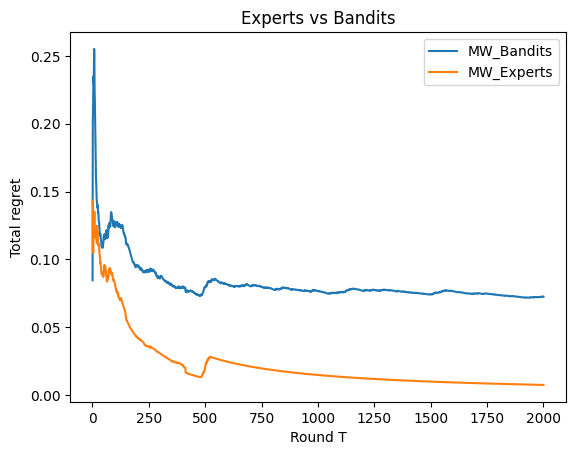

956
1398


In [12]:
mw_band_best_score = np.zeros((T,))     # cumulative reward of best arm for round t
mw_band_inst_score = np.zeros((T,))     # reward for round t
mw_band_score = np.zeros((T,))          # cumulative reward for round t
mw_band_regret =  np.zeros((T,))        # regret for round t
mw_band_correct_predictions= 0

# initialize all weights to 1
weights = [1 for _ in range(EXPERTS)]

# initialize loss
loss = np.zeros((T,))

#initialize probs to pick an expert
probs = [1/EXPERTS for _ in range(EXPERTS)]

# initialize q the new prob to pick
q = [(1-epsilon)*probs[i]+r for i in range(EXPERTS)]

with open("Milano_timeseries.csv", "r") as f:

    # initialize reader
    dataset = list(csv.reader(f))

    servers = 30

    #  for every round
    for round_number in range(T):

        # pick an expert with qi= q
        expert = np.random.choice(EXPERTS, p=q)

        # collect score of the expert
        mw_band_inst_score[round_number] = float(dataset[expert][round_number])

        #intiliaze best_load to infinite
        best_load = float("inf")

        # for every server
        for server_number in range(servers):

            # find the best  server for each round
            if float(dataset[server_number][round_number]) < best_load:
                best_server = server_number
                best_load = float(dataset[server_number][round_number])

    



        #calulate the loss at each round= load of the optimal server - load of picked server
        loss[round_number] = abs(best_load - float(dataset[expert][round_number]))/q[expert]
         #keep track of the correct guesses
        if best_load== mw_band_inst_score[round_number]: mw_band_correct_predictions+=1

        #calculate the weights for every expert even if expert wasnt played
        weights[expert]= np.power(1-bandits_h,loss[round_number])*weights[expert] 

        probs= [weights[i]/sum(weights) for i in range (EXPERTS)]
        

        #update q
        q = [(1-epsilon)*probs[i]+r for i in range(EXPERTS)]

# find MW bandits regret
for i in range(T):
    if i > 0: 
        mw_band_best_score[i] = mw_band_best_score[i-1] + float(dataset[bestof_best][i]) 
        mw_band_score[i] = mw_band_score[i-1] + mw_band_inst_score[i]  
    else: 
        mw_band_best_score[i] = float(dataset[bestof_best][i])
        mw_band_score[i] = mw_band_inst_score[i]

    mw_band_regret[i] = (mw_band_best_score[i] - mw_band_score[i])/(i+1) 

plt.title("Experts vs Bandits")
plt.xlabel("Round T")
plt.ylabel("Total regret")
plt.plot(np.arange(1,T+1),abs(mw_band_regret), label="MW_Bandits")
plt.plot(np.arange(1,T+1),abs(mw_regret), label="MW_Experts")

plt.legend()
plt.show()

print(mw_band_correct_predictions)
print(mw_correct_predictions)